In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import matplotlib.dates as mdates
import datetime as DT
import time

In [2]:
pd.set_option('max_columns', None)

In [3]:
def ebird_import(filename):
    '''imports csv file. creates array for longitude and latitude of sightings. Generates an animated plot of the sightings over time '''
    bird_data = pd.read_csv(filename, sep='\t', usecols=['year', 'month', 'decimalLongitude', 'decimalLatitude'],low_memory=False)
    
    bird_data.dropna()
    drop_old_values = bird_data[bird_data['year']<= 1879].index
    bird_data.drop(drop_old_values, inplace=True)
    
    g = bird_data.groupby(['year','month'], as_index = False)
    monthly_averages = g.aggregate({'decimalLongitude':np.mean,'decimalLatitude':np.mean })
    averages = monthly_averages.dropna(subset=['decimalLongitude','decimalLatitude'])
    
    fig = px.scatter_geo(monthly_averages,
                 lon='decimalLongitude',
                 lat='decimalLatitude',
                 animation_group = 'year',
                 color = 'year',
                 color_continuous_scale = px.colors.sequential.Jet,    
                 animation_frame = 'month',
                 category_orders={'month': range(2500)})
    fig.update_layout(title='Average monthly position by year')
    
    return [fig , averages]

In [13]:
def weather_import(weather_filename):
    '''imports csv file for NASAs GLOBAL LAND-OCEAN TEMPERATURE INDEX. function will also convert into the same date format as the latitude index'''
    df_w = pd.read_csv(weather_filename)
    
    df_w.dropna(how='all')
    temperature_index = pd.melt(df_w, id_vars=['year'], value_vars = ['1','2','3','4','5','6','7','8','9','10','11','12'],var_name = 'month',value_name='temperature variation')
    temperature_index = temperature_index[['month','year','temperature variation']]
    temperature_index.set_index('month','Year')
    temperature_index = temperature_index.assign(date=pd.to_datetime(temperature_index[['year','month']].assign(day=1)))
    return temperature_index

In [5]:
def position_index(filename):
    '''Uses the average position values from the import function, creates a baseline position and calculates a deviation index'''
    average_df = ebird_import(filename)[1]
    avg_filter = average_df.loc[(average_df['year'] >= 1951) & (average_df['year'] <= 1980)]
    month_grouping = avg_filter.groupby(['month'], as_index = True)
    avg_ref = month_grouping.aggregate({'decimalLongitude':np.mean,'decimalLatitude':np.mean })
    aaa = average_df.set_index(['month','year'])
    aba = avg_ref#.set_index(['month'])
    adjusted_long = aaa['decimalLongitude'].sub(aba['decimalLongitude'],axis = 'index')
    adjusted_lat = aaa['decimalLatitude'].sub(aba['decimalLatitude'],axis = 'index')
    adjusted_df = pd.merge(adjusted_long, adjusted_lat, right_index=True,left_index = True)
    #adjusted_df.reset_index(drop=True)
    #adjusted_df = adjusted_df.assign(date=pd.to_datetime(adjusted_df[['year','month']].assign(day=1)))
    #adjusted_lat = adjusted_lat.assign(date=pd.to_datetime(adjusted_lat[['year','month']].assign(day=1)))
    adjusted_lat = adjusted_lat.to_frame()
    adjusted_lat.reset_index(inplace=True)
    adjusted_lat = adjusted_lat.assign(date=pd.to_datetime(adjusted_lat[['year','month']].assign(day=1)))
    
    return adjusted_lat

In [40]:
def temperature_plot(filename):
    '''Uses an inputted csv file for the tempearature data and plots it along with a 5th order regression'''
    x = weather_import(filename)
    plt.figure(figsize=(12,10))
    plt.scatter(x['date'],x['temperature variation'],s = 5)
    plt.title('Temperature Variance of Average 1950-1980 Values')
    plt.ylabel('Degree Celsius Difference from Average')
    plt.xlabel('Year')

    dd = mdates.date2num(x['date'])
    pfit5 = np.polyfit(dd,x['temperature variation'],5)
    p5 = np.poly1d(pfit5)

    plt.scatter(dd,p5(dd),s=5)
    return

In [42]:
def position_plot(filename):
    '''Uses the position index function to plot the data and apply a linear regression'''
    y = position_index(filename)
    plt.figure(figsize=(12,10))
    plt.scatter(y['date'],y['decimalLatitude'],s=5)
    plt.ylim(-15,15)
    plt.title('Latitude Variance of Average 1950-1980 Values')
    plt.ylabel('Degree Latitude Difference from Average')
    plt.xlabel('Year')

    dt=mdates.date2num(y['date'])
    pfit1 = np.polyfit(dt,y['decimalLatitude'],1)
    p1 = np.poly1d(pfit1)
    plt.scatter(dt,p1(dt),s=5)
    
    return

In [44]:
ebird_import('ac_loon.csv')[0]

The change in global surface temperature relative to 1951-1980 average temperatures.

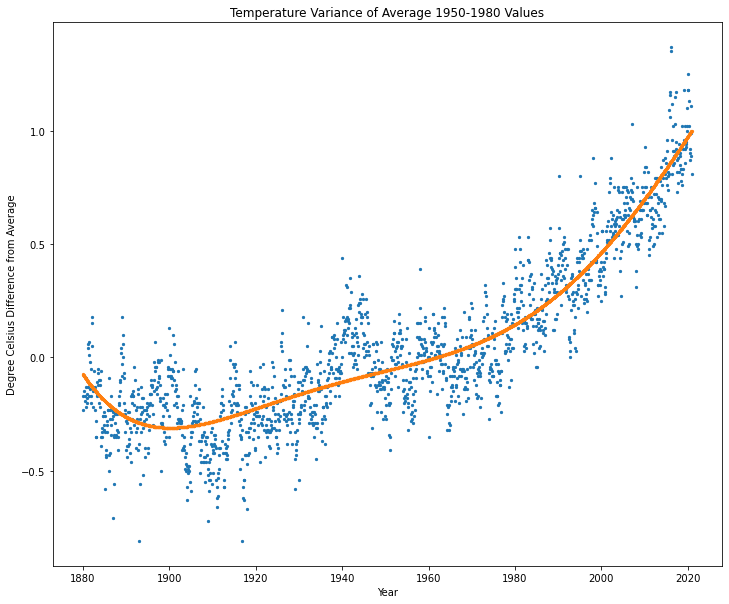

In [41]:
temperature_plot('gloti_data.csv')

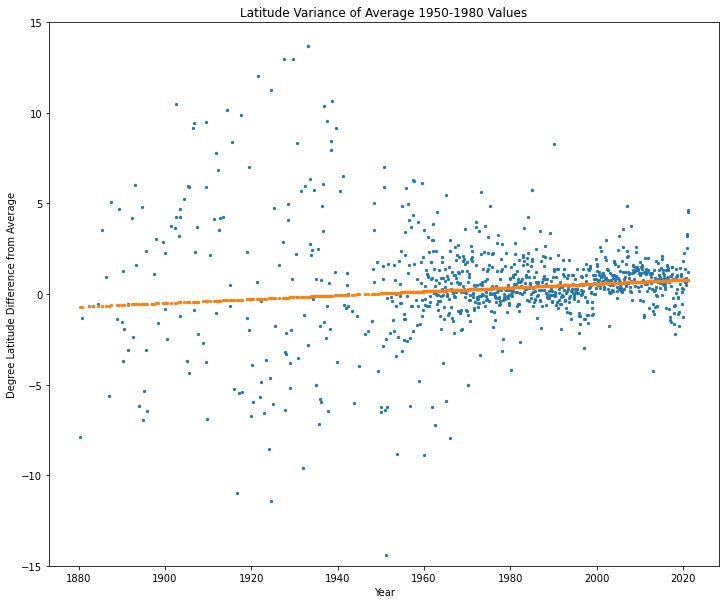

In [43]:
position_plot('ac_loon.csv')